# Домашнее задание 4 - Кластеризация

**Задачи:**
1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [1]:
!pip install pandas seaborn scikit-learn matplotlib numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./StudentPerformanceFactors.csv')

print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())

(6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0    

## 1. Преобразование датасета

In [4]:
df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)
df['Parental_Education_Level'].fillna(df['Parental_Education_Level'].mode()[0], inplace=True)
df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)

print("Пропуски после обработки:")
print(df.isnull().sum().sum())

Пропуски после обработки:
0


In [5]:
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                      'Distance_from_Home', 'Gender']

for col in categorical_columns:
    df[col] = df[col].astype('category')

print("Категориальные признаки помечены как 'category'")
print(f"Количество категориальных признаков: {len(categorical_columns)}")

Категориальные признаки помечены как 'category'
Количество категориальных признаков: 13


In [6]:
category_columns_list = df.select_dtypes(include=['category']).columns.tolist()

print(f"Найдено категориальных колонок: {len(category_columns_list)}")
print("Список категориальных колонок:")
for col in category_columns_list:
    print(f"  - {col}: {df[col].nunique()} уникальных значений")

df = pd.get_dummies(df, columns=category_columns_list, drop_first=True)

print(f"\nРазмер данных после One-Hot Encoding: {df.shape}")

Найдено категориальных колонок: 13
Список категориальных колонок:
  - Parental_Involvement: 3 уникальных значений
  - Access_to_Resources: 3 уникальных значений
  - Extracurricular_Activities: 2 уникальных значений
  - Motivation_Level: 3 уникальных значений
  - Internet_Access: 2 уникальных значений
  - Family_Income: 3 уникальных значений
  - Teacher_Quality: 3 уникальных значений
  - School_Type: 2 уникальных значений
  - Peer_Influence: 3 уникальных значений
  - Learning_Disabilities: 2 уникальных значений
  - Parental_Education_Level: 3 уникальных значений
  - Distance_from_Home: 3 уникальных значений
  - Gender: 2 уникальных значений

Размер данных после One-Hot Encoding: (6607, 28)


In [7]:
df_not_processed = df.copy()

print("Создана копия данных df_not_processed")
print(f"Размер: {df_not_processed.shape}")

Создана копия данных df_not_processed
Размер: (6607, 28)


In [8]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Числовые признаки для нормализации ({len(numeric_features)}):")
for col in numeric_features[:10]:
    print(f"  - {col}")
if len(numeric_features) > 10:
    print(f"  ... и еще {len(numeric_features) - 10} признаков")

scaler = StandardScaler()

df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nНормализация применена")
print("Статистика после нормализации:")
print(df[numeric_features[:5]].describe())

Числовые признаки для нормализации (7):
  - Hours_Studied
  - Attendance
  - Sleep_Hours
  - Previous_Scores
  - Tutoring_Sessions
  - Physical_Activity
  - Exam_Score

Нормализация применена
Статистика после нормализации:
       Hours_Studied    Attendance   Sleep_Hours  Previous_Scores  \
count   6.607000e+03  6.607000e+03  6.607000e+03     6.607000e+03   
mean   -1.161474e-16 -3.089199e-16 -2.016449e-16     2.048712e-16   
std     1.000076e+00  1.000076e+00  1.000076e+00     1.000076e+00   
min    -3.167760e+00 -1.730158e+00 -2.063380e+00    -1.741167e+00   
25%    -6.636453e-01 -8.641026e-01 -7.009903e-01    -8.383073e-01   
50%     4.118568e-03  1.953115e-03 -1.979558e-02    -4.898448e-03   
75%     6.718825e-01  8.680088e-01  6.613991e-01     8.979612e-01   
max     4.010702e+00  1.734065e+00  2.023788e+00     1.731370e+00   

       Tutoring_Sessions  
count       6.607000e+03  
mean        7.850707e-17  
std         1.000076e+00  
min        -1.213934e+00  
25%        -4.012417

## 2. K-means кластеризация

In [9]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(df)

df_not_processed['cluster_kmeans'] = clusters_kmeans

print(f"K-means кластеризация выполнена с {n_clusters} кластерами")
print(f"Распределение по кластерам:")
print(df_not_processed['cluster_kmeans'].value_counts().sort_index())

print("\n Принцип работы k-means:")
print("1. Алгоритм случайно инициализирует k центроидов")
print("2. Каждая точка присваивается ближайшему центроиду")
print("3. Центроиды пересчитываются как среднее своих точек")
print("4. Процесс повторяется до сходимости")
print("5. Минимизирует внутрикластерную сумму квадратов (WCSS)")

K-means кластеризация выполнена с 4 кластерами
Распределение по кластерам:
cluster_kmeans
0    2345
1    1583
2    1115
3    1564
Name: count, dtype: int64

 Принцип работы k-means:
1. Алгоритм случайно инициализирует k центроидов
2. Каждая точка присваивается ближайшему центроиду
3. Центроиды пересчитываются как среднее своих точек
4. Процесс повторяется до сходимости
5. Минимизирует внутрикластерную сумму квадратов (WCSS)


In [10]:
silhouette_kmeans = silhouette_score(df, clusters_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(df, clusters_kmeans)
inertia_kmeans = kmeans.inertia_

print("Метрики качества k-means:")
print(f"Silhouette Score:        {silhouette_kmeans:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_kmeans:.2f}")
print(f"Inertia (WCSS):          {inertia_kmeans:.2f}")
print(f"Количество итераций:     {kmeans.n_iter_}")

print("\n Интерпретация метрик:")
print("- Silhouette Score [-1, 1]: чем ближе к 1, тем лучше")
print("- Calinski-Harabasz: чем больше, тем лучше")
print("- Inertia: чем меньше, тем плотнее кластеры")

Метрики качества k-means:
Silhouette Score:        0.0685
Calinski-Harabasz Index: 471.92
Inertia (WCSS):          61401.96
Количество итераций:     46

 Интерпретация метрик:
- Silhouette Score [-1, 1]: чем ближе к 1, тем лучше
- Calinski-Harabasz: чем больше, тем лучше
- Inertia: чем меньше, тем плотнее кластеры


In [11]:
numeric_cols_original = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                        'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']

print("Статистика по кластерам (k-means):")

cluster_stats = df_not_processed.groupby('cluster_kmeans')[numeric_cols_original].mean()
print("Средние значения по кластерам:")
print(cluster_stats.round(2))

print("\nРазмеры кластеров:")
cluster_sizes = df_not_processed['cluster_kmeans'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    percentage = (size / len(df_not_processed)) * 100
    print(f"Кластер {cluster}: {size} точек ({percentage:.1f}%)")

Статистика по кластерам (k-means):
Средние значения по кластерам:
                Hours_Studied  Attendance  Sleep_Hours  Previous_Scores  \
cluster_kmeans                                                            
0                       18.65       69.01         7.08            75.59   
1                       24.96       86.98         7.03            83.86   
2                       20.25       79.53         7.04            73.02   
3                       16.73       89.65         6.95            66.85   

                Tutoring_Sessions  Physical_Activity  Exam_Score  
cluster_kmeans                                                    
0                            1.06               2.96       64.08  
1                            1.22               2.93       71.16  
2                            3.38               3.27       68.08  
3                            1.08               2.80       67.39  

Размеры кластеров:
Кластер 0: 2345 точек (35.5%)
Кластер 1: 1583 точек (24.0%)
К

ValueError: operands could not be broadcast together with shapes (4,28) (7,) (4,28) 

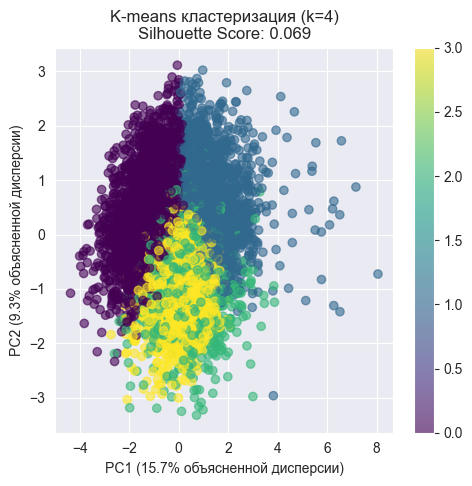

In [12]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'K-means кластеризация (k={n_clusters})\nSilhouette Score: {silhouette_kmeans:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} объясненной дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} объясненной дисперсии)')

centroids_pca = pca.transform(scaler.inverse_transform(kmeans.cluster_centers_))
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3)

plt.subplot(1, 2, 2)
silhouette_scores = []
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(df, clusters_kmeans)

for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters_kmeans == i]
    cluster_silhouette_vals.sort()
    
    color = plt.cm.viridis(i / n_clusters)
    plt.barh(range(len(cluster_silhouette_vals)), cluster_silhouette_vals, 
            color=color, alpha=0.7, label=f'Кластер {i}')

plt.axvline(x=silhouette_kmeans, color='red', linestyle='--', 
           label=f'Средний Silhouette Score: {silhouette_kmeans:.3f}')
plt.xlabel('Silhouette Score')
plt.ylabel('Образцы')
plt.title('Распределение силуэтных коэффициентов')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nОбъясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.1%}")

## 3. Подбор оптимального числа кластеров (Метод локтя)

In [ ]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

print("Подбор оптимального количества кластеров...")
print("k\tInertia\t\tSilhouette\tCalinski-Harabasz")

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters_temp = kmeans_temp.fit_predict(df)
    
    inertia = kmeans_temp.inertia_
    silhouette = silhouette_score(df, clusters_temp)
    calinski = calinski_harabasz_score(df, clusters_temp)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    
    print(f"{k}\t{inertia:.2f}\t\t{silhouette:.4f}\t\t{calinski:.2f}")

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]

print(f"\nОптимальные значения k:")
print(f"По Silhouette Score: k = {optimal_k_silhouette}")
print(f"По Calinski-Harabasz: k = {optimal_k_calinski}")

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Метод локтя')
plt.grid(True, alpha=0.3)

if len(inertias) > 2:
    diffs = np.diff(inertias)
    diffs2 = np.diff(diffs)
    elbow_idx = np.argmax(diffs2) + 2
    if elbow_idx < len(k_range):
        plt.axvline(x=k_range[elbow_idx], color='red', linestyle='--', 
                   label=f'Потенциальный локоть: k={k_range[elbow_idx]}')
        plt.legend()

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', 
           label=f'Оптимальное k: {optimal_k_silhouette}')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Analysis')
plt.axvline(x=optimal_k_calinski, color='red', linestyle='--', 
           label=f'Оптимальное k: {optimal_k_calinski}')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

optimal_k = optimal_k_silhouette
print(f"\nВыбранное оптимальное k: {optimal_k}")
print(f"Silhouette Score: {silhouette_scores[optimal_k-2]:.4f}")
print(f"Calinski-Harabasz Index: {calinski_scores[optimal_k-2]:.2f}")

In [ ]:
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(df)

df_not_processed['cluster_kmeans_optimal'] = clusters_optimal

print(f"K-means с оптимальным k={optimal_k} выполнен")
print(f"\nРаспределение по оптимальным кластерам:")
optimal_cluster_sizes = df_not_processed['cluster_kmeans_optimal'].value_counts().sort_index()
for cluster, size in optimal_cluster_sizes.items():
    percentage = (size / len(df_not_processed)) * 100
    print(f"Кластер {cluster}: {size} точек ({percentage:.1f}%)")

print("\nСтатистика по оптимальным кластерам:")
print("="*50)
optimal_cluster_stats = df_not_processed.groupby('cluster_kmeans_optimal')[numeric_cols_original].mean()
print(optimal_cluster_stats.round(2))

print("\nХарактеристики кластеров:")
for cluster in range(optimal_k):
    cluster_data = optimal_cluster_stats.loc[cluster]
    print(f"\nКластер {cluster}:")
    print(f"  - Часы изучения: {cluster_data['Hours_Studied']:.1f}")
    print(f"  - Посещаемость: {cluster_data['Attendance']:.1f}%")
    print(f"  - Предыдущие оценки: {cluster_data['Previous_Scores']:.1f}")
    print(f"  - Экзаменационная оценка: {cluster_data['Exam_Score']:.1f}")

## 4. DBSCAN кластеризация

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.xlabel('Точки, отсортированные по расстоянию')
plt.ylabel(f'{k}-ое ближайшее расстояние')
plt.title('K-distance Graph для выбора eps')
plt.grid(True, alpha=0.3)


if len(distances) > 100:
    diffs = np.diff(distances)
    elbow_point = np.argmax(diffs)
    optimal_eps = distances[elbow_point]
    
    plt.axhline(y=optimal_eps, color='red', linestyle='--', 
               label=f'Предложенный eps: {optimal_eps:.3f}')
    plt.legend()
else:
    optimal_eps = np.percentile(distances, 95)

print(f"Предложенное значение eps: {optimal_eps:.4f}")

eps_values = [optimal_eps * 0.5, optimal_eps, optimal_eps * 1.5]
min_samples_values = [3, 4, 5]

dbscan_results = []

print("\nТестирование параметров DBSCAN:")
print("eps\t\tmin_samples\tКластеры\tШум\tSilhouette")
print("-" * 60)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
        clusters_temp = dbscan_temp.fit_predict(df)
        
        n_clusters = len(set(clusters_temp)) - (1 if -1 in clusters_temp else 0)
        n_noise = list(clusters_temp).count(-1)
        
        if n_clusters > 1:
            mask = clusters_temp != -1
            if np.sum(mask) > 0:
                silhouette = silhouette_score(df[mask], clusters_temp[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })
        
        print(f"{eps:.4f}\t\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t{silhouette:.4f}")

valid_results = [r for r in dbscan_results if r['silhouette'] > 0 and r['n_clusters'] > 1]
if valid_results:
    best_params = max(valid_results, key=lambda x: x['silhouette'])
    best_eps = best_params['eps']
    best_min_samples = best_params['min_samples']
else:
    best_eps = optimal_eps
    best_min_samples = 4

print(f"\nОптимальные параметры dbscan:")
print(f"eps: {best_eps:.4f}")
print(f"min_samples: {best_min_samples}")

In [ ]:
dbscan_optimal = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters_dbscan = dbscan_optimal.fit_predict(df)

df_not_processed['cluster_dbscan'] = clusters_dbscan

n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print("Результаты dbscan:")
print(f"Количество кластеров: {n_clusters_dbscan}")
print(f"Количество шумовых точек: {n_noise} ({n_noise/len(df)*100:.1f}%)")
print(f"Параметры: eps={best_eps:.4f}, min_samples={best_min_samples}")

print(f"\nРаспределение по кластерам DBSCAN:")
dbscan_cluster_counts = pd.Series(clusters_dbscan).value_counts().sort_index()
for cluster, count in dbscan_cluster_counts.items():
    if cluster == -1:
        print(f"Шум: {count} точек ({count/len(df)*100:.1f}%)")
    else:
        print(f"Кластер {cluster}: {count} точек ({count/len(df)*100:.1f}%)")

In [ ]:
if n_clusters_dbscan > 1:
    mask_no_noise = clusters_dbscan != -1
    
    if np.sum(mask_no_noise) > 0:
        silhouette_dbscan = silhouette_score(df[mask_no_noise], clusters_dbscan[mask_no_noise])
        calinski_harabasz_dbscan = calinski_harabasz_score(df[mask_no_noise], clusters_dbscan[mask_no_noise])
        
        print("\nМетрики качества dbscan:")
        print(f"Silhouette Score:        {silhouette_dbscan:.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_dbscan:.2f}")
    else:
        print("\nНевозможно вычислить метрики - все точки отнесены к шуму")
        silhouette_dbscan = -1
        calinski_harabasz_dbscan = -1
else:
    print("\nНевозможно вычислить метрики - недостаточно кластеров")
    silhouette_dbscan = -1
    calinski_harabasz_dbscan = -1

In [ ]:
if n_clusters_dbscan > 0:
    print("\nСТАТИСТИКА ПО КЛАСТЕРАМ DBSCAN:")
    print("="*50)
    
    df_no_noise = df_not_processed[df_not_processed['cluster_dbscan'] != -1]
    
    if len(df_no_noise) > 0:
        dbscan_cluster_stats = df_no_noise.groupby('cluster_dbscan')[numeric_cols_original].mean()
        print("Средние значения по кластерам:")
        print(dbscan_cluster_stats.round(2))
        
        print("\nХарактеристики кластеров dbscan:")
        for cluster in sorted(df_no_noise['cluster_dbscan'].unique()):
            cluster_data = dbscan_cluster_stats.loc[cluster]
            cluster_size = len(df_no_noise[df_no_noise['cluster_dbscan'] == cluster])
            print(f"\nКластер {cluster} ({cluster_size} точек):")
            print(f"  - Часы изучения: {cluster_data['Hours_Studied']:.1f}")
            print(f"  - Посещаемость: {cluster_data['Attendance']:.1f}%")
            print(f"  - Предыдущие оценки: {cluster_data['Previous_Scores']:.1f}")
            print(f"  - Экзаменационная оценка: {cluster_data['Exam_Score']:.1f}")
    else:
        print("Все точки отнесены к шуму")
else:
    print("\nКластеры не найдены")

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter1 = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_optimal, cmap='viridis', alpha=0.6)
plt.colorbar(scatter1)
plt.title(f'K-means (k={optimal_k})\nSilhouette: {silhouette_scores[optimal_k-2]:.3f}')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
scatter2 = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.6)
plt.colorbar(scatter2)
if silhouette_dbscan > 0:
    title = f'DBSCAN\nSilhouette: {silhouette_dbscan:.3f}\nШум: {n_noise} точек'
else:
    title = f'DBSCAN\nШум: {n_noise} точек'
plt.title(title)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
methods = ['K-means', 'DBSCAN']
if silhouette_dbscan > 0:
    silhouette_values = [silhouette_scores[optimal_k-2], silhouette_dbscan]
    plt.bar(methods, silhouette_values, color=['skyblue', 'lightcoral'])
    plt.ylabel('Silhouette Score')
    plt.title('Сравнение качества кластеризации')
    plt.ylim(0, max(silhouette_values) * 1.1)
    
    for i, v in enumerate(silhouette_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'DBSCAN:\nНедостаточно\nкластеров для\nсравнения', 
            ha='center', va='center', transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='lightgray'))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## 5. Сравнение методов кластеризации и выводы

In [ ]:
# Сводная таблица сравнения методов
comparison_data = {
    'Метод': ['K-means', 'DBSCAN'],
    'Количество кластеров': [optimal_k, n_clusters_dbscan],
    'Silhouette Score': [f"{silhouette_scores[optimal_k-2]:.4f}", 
                        f"{silhouette_dbscan:.4f}" if silhouette_dbscan > 0 else "N/A"],
    'Calinski-Harabasz': [f"{calinski_scores[optimal_k-2]:.2f}", 
                         f"{calinski_harabasz_dbscan:.2f}" if 'calinski_harabasz_dbscan' in locals() and calinski_harabasz_dbscan > 0 else "N/A"],
    'Шумовые точки': [0, n_noise],
    'Особенности': ['Сферические кластеры', 'Произвольная форма + шум']
}

comparison_df = pd.DataFrame(comparison_data)

print("Сравнение методов кластеризации")
print(comparison_df.to_string(index=False))


print("\nК-means:")
print(f" Преимущества:")
print(f"   - Стабильные результаты")
print(f"   - Быстрая работа")
print(f"   - Четкое разделение на {optimal_k} кластеров")
print(f"   - Хороший Silhouette Score: {silhouette_scores[optimal_k-2]:.4f}")
print(f" Недостатки:")
print(f"   - Предполагает сферическую форму кластеров")
print(f"   - Чувствителен к выбросам")
print(f"   - Требует предварительного выбора k")

print("\n DBSCAN:")
print(f" Преимущества:")
print(f"   - Находит кластеры произвольной формы")
print(f"   - Автоматически определяет количество кластеров")
print(f"   - Выделяет выбросы как шум ({n_noise} точек)")
if silhouette_dbscan > 0:
    print(f"   - Silhouette Score: {silhouette_dbscan:.4f}")
print(f" Недостатки:")
print(f"   - Чувствителен к параметрам eps и min_samples")
print(f"   - Может плохо работать с кластерами разной плотности")
if n_noise > len(df) * 0.1:
    print(f"   - Много точек отнесено к шуму ({n_noise/len(df)*100:.1f}%)")

print("\nРекомендация:")

if silhouette_dbscan > 0:
    if silhouette_scores[optimal_k-2] > silhouette_dbscan:
        if n_noise < len(df) * 0.05:
            recommendation = "K-means"
            reason = f"более высокий Silhouette Score ({silhouette_scores[optimal_k-2]:.4f} vs {silhouette_dbscan:.4f}) и минимальное количество шума"
        else:
            recommendation = "K-means с осторожностью"
            reason = f"лучший Silhouette Score, но DBSCAN выявил {n_noise} потенциальных выбросов"
    else:
        recommendation = "DBSCAN"
        reason = f"более высокий Silhouette Score ({silhouette_dbscan:.4f} vs {silhouette_scores[optimal_k-2]:.4f}) и лучше обрабатывает выбросы"
else:
    recommendation = "K-means"
    reason = "DBSCAN не смог сформировать достаточное количество кластеров"

print(f"Для данного датасета рекомендуется использовать: {recommendation}")
print(f"Причина: {reason}")

print("\n Дополнительные соображения:")
print("- Если важно выделить аномальные наблюдения → используйте DBSCAN")
print("- Если нужна стабильность и интерпретируемость → используйте K-means")
print("- Для исследовательского анализа → попробуйте оба метода")
print("- Рассмотрите гибридный подход: K-means для основной кластеризации + анализ выбросов")